<a href="https://colab.research.google.com/github/HardikPrabhu/XAI-for-Energy-Prediction-and-Anomaly-Detection-on-GEP-dataset/blob/main/xai_for_anom_detect_energy_predict_building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
path = "/content/drive/MyDrive/anomaly_data/" # data location
os.chdir(path)

Mounted at /content/drive


# Imports and model class

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 6.9 MB/s eta 0:00:00


In [ ]:
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from tqdm import tqdm, trange
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from sklearn.linear_model import LogisticRegression, LinearRegression

from imblearn.over_sampling import RandomOverSampler
import pickle
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly

# Input data files are available i

import datetime

import shap
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def add_cyclic(df):
    # time interactions
    # apply cyclic encoding of periodic features
    new_df = df.copy()
    new_df["hour_x"] = np.cos(2*np.pi*df["hour"]/24)
    new_df["hour_y"] = np.sin(2*np.pi*df["hour"]/24)

    new_df["month_x"] = np.cos(2*np.pi*df["month"]/30.4)
    new_df["month_y"] = np.sin(2*np.pi*df["month"]/30.4)

    new_df["weekday_x"] = np.cos(2*np.pi*df["weekday"]/7)
    new_df["weekday_y"] = np.sin(2*np.pi*df["weekday"]/7)

    return new_df


In [ ]:
# Required for SHAP analysis later (run it)

class Black_box_model():
  def __init__(self,base_model,scaling =False):
      self.base_model = base_model
      self.scaling = False

  def fit(self,X_train,Y_train):

    X_train = add_cyclic(X_train)

    if self.scaling:
      self.scaler = StandardScaler()
      X_train = self.scaler.fit_transform(X_train)
    self.base_model.fit(X_train,Y_train)

  def predict(self,X_test):

    X_test = add_cyclic(X_test)


    if self.scaling:
       X_test = self.scaler.transform(X_test)
    return  self.base_model.predict(X_test)

  def predict_proba(self,X_test):


    X_test = add_cyclic(X_test)


    if self.scaling:
       X_test = self.scaler.transform(X_test)
    return  self.base_model.predict_proba(X_test)











# Start from here (skip)

In [ ]:

def impute_nulls(data):
    mean_reading = data.groupby('building_id').mean()['meter_reading']

    building_id = mean_reading.index
    values = mean_reading.values

    for i, idx in tqdm(enumerate(building_id)):
        data[data['building_id']==idx] = data[data['building_id']==idx].fillna(values[i])

    return data


In [ ]:
train = pd.read_csv("train_features.csv")
train.shape # size

(1749494, 57)

In [ ]:
train.columns

Index(['building_id', 'timestamp', 'meter_reading', 'anomaly', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'air_temperature_mean_lag7', 'air_temperature_max_lag7',
       'air_temperature_min_lag7', 'air_temperature_std_lag7',
       'air_temperature_mean_lag73', 'air_temperature_max_lag73',
       'air_temperature_min_lag73', 'air_temperature_std_lag73', 'hour',
       'weekday', 'month', 'year', 'weekday_hour', 'hour_x', 'hour_y',
       'month_x', 'month_y', 'weekday_x', 'weekday_y', 'building_weekday_hour',
       'building_weekday', 'building_month', 'building_hour', 'building_meter',
       'is_holiday', 'gte_hour', 'gte_weekday', 'gte_month', 'gte_building_id',
       'gte_primary_use', 'gte_site_id', 'gte_meter', 'gte_meter_hour',
       'gte_meter_weekday', 'gte_meter_month', 'gte_meter_building

In [ ]:
train = train[['building_id', 'timestamp', 'meter_reading', 'anomaly', 'site_id',
        'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'hour',
       'weekday', 'month', 'year',
       'is_holiday']]

In [ ]:
# fix the bug in cloud coverage values
train['cloud_coverage'] = train['cloud_coverage'].replace({255:10})
train.head()

,building_id,timestamp,meter_reading,anomaly,site_id,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,weekday,month,year,is_holiday
0,1,2016-01-01 00:00:00,NaN,0,0,2720,104,0,19.4,10,19.4,0,967.2,0,0.0,0,4,1,2016,1
1,32,2016-01-01 00:00:00,NaN,0,0,48392,105,0,19.4,10,19.4,0,967.2,0,0.0,0,4,1,2016,1
2,41,2016-01-01 00:00:00,NaN,0,0,93860,68,0,19.4,10,19.4,0,967.2,0,0.0,0,4,1,2016,1
3,55,2016-01-01 00:00:00,NaN,0,0,16726,111,0,19.4,10,19.4,0,967.2,0,0.0,0,4,1,2016,1
4,69,2016-01-01 00:00:00,NaN,0,0,387638,100,0,19.4,10,19.4,0,967.2,0,0.0,0,4,1,2016,1


In [ ]:
train = train.drop(['year'], axis=1)

In [ ]:
train.shape

(1749494, 19)

In [ ]:
"""
train_feature =  pd.read_csv("train_features.csv")
train_feature = impute_nulls(train_feature)
for shift_hours in tqdm([1,2,4,6,9,12]):
    meter_reading_shift = train_feature[['building_id', 'timestamp', 'meter_reading']]
    meter_reading_shift['timestamp'] = pd.to_datetime(meter_reading_shift['timestamp']) + datetime.timedelta(hours=shift_hours)
    meter_reading_shift['timestamp'] = meter_reading_shift['timestamp'].astype('str')
    meter_reading_shift = meter_reading_shift.rename(columns={'meter_reading':'meter_t-'+str(shift_hours)})
    train_feature = train_feature.merge(meter_reading_shift, on=['building_id', 'timestamp'], how='left')
    train['meter_t-'+str(shift_hours)] = train_feature['meter_t-'+str(shift_hours)]

del train_feature
"""


200it [00:33,  6.06it/s]
100%|██████████| 6/6 [00:44<00:00,  7.43s/it]


In [ ]:
# store the processed data as pickle objects
import pickle

with open("train_data_forecast.pkl", "wb") as input_file:
  pickle.dump(train,input_file)



# Training Energy Prediction Model (skip)

In [ ]:
# Energy Predictions : start here

with open("train_data_forecast.pkl", "rb") as input_file: # train_data is preprocessed the LEAD competiton train data
  train = pickle.load(input_file)

train = train.dropna()


train.columns

Index(['building_id', 'timestamp', 'meter_reading', 'anomaly', 'site_id',
       'square_feet', 'year_built', 'floor_count', 'air_temperature',
       'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr',
       'sea_level_pressure', 'wind_direction', 'wind_speed', 'hour', 'weekday',
       'month', 'is_holiday'],
      dtype='object')

In [ ]:
X_train = train[train['month']<9]
X_test = train[train["month"]>=9]




In [ ]:
sum(X_train["anomaly"])/len(X_train)

0.024366202772658094

In [ ]:
Y_train = X_train["meter_reading"]
X_train = X_train.drop(columns = ["meter_reading","anomaly","timestamp"])
Y_test = X_test["meter_reading"]
X_test = X_test.drop(columns = ["meter_reading","anomaly","timestamp"])



In [ ]:
X_train.columns

Index(['building_id', 'site_id', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'hour', 'weekday', 'month', 'is_holiday'],
      dtype='object')

In [ ]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_log_error
base_model =  lgb.LGBMRegressor()
bb_model = Black_box_model(base_model)
bb_model.fit(X_train,Y_train)
Y_pred = bb_model.predict(X_test)
r2_score(Y_test,Y_pred)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.203143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1450
[LightGBM] [Info] Number of data points in the train set: 1083509, number of used features: 22
[LightGBM] [Info] Start training from score 181.065408


0.9751282495163255

In [ ]:
# save the model ...

with open("lgbm_forecast.pkl", "wb") as input_file: # save the lgbm model
  train = pickle.dump(bb_model,input_file)



In [ ]:
# comparing diffrent models
models = [Black_box_model(lgb.LGBMRegressor(),scaling=True), Black_box_model(LinearRegression(),scaling= True)]

for model in models:
  model.fit(X_train,Y_train)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.462951 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1450
[LightGBM] [Info] Number of data points in the train set: 1083509, number of used features: 22
[LightGBM] [Info] Start training from score 181.065408


In [ ]:
# predictions of each models :-
predictions = []
for model in models:
  Y_pred = model.predict(X_test)
  predictions.append(Y_pred)


In [ ]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
r = []
mae = []
rmse = []
for y_pred in predictions:
  r.append(r2_score(Y_test,y_pred))
  mae.append(mean_absolute_error(Y_test,y_pred))
  rmse.append(mean_squared_error(Y_test,y_pred))


In [ ]:
r, mae, rmse

([0.9751282495163255, 0.38586613853487484],
 [28.201040675271575, 144.9915370995517],
 [3612.922023578168, 89210.35754877217])

# Training Anom detect model (skip)

In [ ]:

with open("train_data_forecast.pkl", "rb") as input_file:
  train = pickle.load(input_file)

train = train.dropna()


train.columns


Index(['building_id', 'timestamp', 'meter_reading', 'anomaly', 'site_id',
       'square_feet', 'year_built', 'floor_count', 'air_temperature',
       'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr',
       'sea_level_pressure', 'wind_direction', 'wind_speed', 'hour', 'weekday',
       'month', 'is_holiday'],
      dtype='object')

In [ ]:
# purely for anomaly detection ...
train_feature =  pd.read_csv("train_features.csv")
train_feature = impute_nulls(train_feature)
for shift_hours in tqdm([-1,1,2,-2,3,-3,5,-5,12,-12,-24,24,-7*24,7*24]):
    meter_reading_shift = train_feature[['building_id', 'timestamp', 'meter_reading']]
    meter_reading_shift['timestamp'] = pd.to_datetime(meter_reading_shift['timestamp']) + datetime.timedelta(hours=shift_hours)
    meter_reading_shift['timestamp'] = meter_reading_shift['timestamp'].astype('str')
    meter_reading_shift = meter_reading_shift.rename(columns={'meter_reading':'lag_value_'+str(shift_hours)})
    train_feature = train_feature.merge(meter_reading_shift, on=['building_id', 'timestamp'], how='left')
    train["val_change_ratio" + str(shift_hours)] = (train_feature['meter_reading'] +1 / 1 + train_feature['lag_value_'+str(shift_hours)])
    train['lag_value_'+str(shift_hours)] = train_feature['lag_value_'+str(shift_hours)]-train_feature['meter_reading']


200it [00:31,  6.32it/s]
100%|██████████| 14/14 [01:46<00:00,  7.60s/it]


In [ ]:
train.columns


Index(['building_id', 'timestamp', 'meter_reading', 'anomaly', 'site_id',
       'square_feet', 'year_built', 'floor_count', 'air_temperature',
       'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr',
       'sea_level_pressure', 'wind_direction', 'wind_speed', 'hour', 'weekday',
       'month', 'is_holiday', 'val_change_ratio-1', 'lag_value_-1',
       'val_change_ratio1', 'lag_value_1', 'val_change_ratio2', 'lag_value_2',
       'val_change_ratio-2', 'lag_value_-2', 'val_change_ratio3',
       'lag_value_3', 'val_change_ratio-3', 'lag_value_-3',
       'val_change_ratio5', 'lag_value_5', 'val_change_ratio-5',
       'lag_value_-5', 'val_change_ratio12', 'lag_value_12',
       'val_change_ratio-12', 'lag_value_-12', 'val_change_ratio-24',
       'lag_value_-24', 'val_change_ratio24', 'lag_value_24',
       'val_change_ratio-168', 'lag_value_-168', 'val_change_ratio168',
       'lag_value_168'],
      dtype='object')

In [ ]:
trainwona = train.dropna()
trainwona = trainwona.drop(columns = ["timestamp"])

with open("train_data_anom.pkl", "wb") as input_file:
  pickle.dump(trainwona,input_file)


In [ ]:
from sklearn.metrics import roc_auc_score
# comparing diffrent models
models = [Black_box_model(lgb.LGBMClassifier(),scaling=True), Black_box_model(LogisticRegression(),scaling= True)]
m =0
roc = []
for model in models:

    X_train = trainwona[trainwona['month']<9]
    X_test = trainwona[trainwona["month"]>=9]



    neg = X_train[X_train['anomaly'] == 0]
    pos = X_train[X_train['anomaly'] == 1]
    neg = neg.sample(n = len(pos), random_state=10)
    X_train = pd.concat([neg, pos], axis=0)


    Y_train = X_train["anomaly"]
    X_train = X_train.drop(columns = ["anomaly"])

    Y_test = X_test["anomaly"]
    X_test = X_test.drop(columns = ["anomaly"])
    model.fit(X_train,Y_train)
    # predictions of each models :-

    Y_pred = model.predict_proba(X_test)[:,1]
    predictions.append(Y_pred)
    roc.append(roc_auc_score(Y_test,Y_pred))



[LightGBM] [Info] Number of positive: 23300, number of negative: 23300
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8814
[LightGBM] [Info] Number of data points in the train set: 46600, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [ ]:
roc

[0.9591304774190212, 0.6707323815798937]

In [ ]:
bb_model = models[0]

with open("lgbm_anomdetect.pkl", "wb") as input_file: # save the lgbm model
 pickle.dump(bb_model,input_file)



# SHAP Explainations

Energy Prediction

In [ ]:
# get Data
with open("train_data_forecast.pkl", "rb") as input_file:
  train = pickle.load(input_file)

train = train.dropna()


print(train.columns)

# get model
with open("lgbm_forecast.pkl", "rb") as input_file: # lgbm model
  bb_model = pickle.load(input_file)


Index(['building_id', 'timestamp', 'meter_reading', 'anomaly', 'site_id',
       'square_feet', 'year_built', 'floor_count', 'air_temperature',
       'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr',
       'sea_level_pressure', 'wind_direction', 'wind_speed', 'hour', 'weekday',
       'month', 'is_holiday'],
      dtype='object')


In [ ]:
X_train = train[train['month']<9]
X_test = train[train["month"]>=9]

Y_train = X_train["meter_reading"]
X_train = X_train.drop(columns = ["meter_reading","anomaly","timestamp"])
Y_test = X_test["meter_reading"]
X_test = X_test.drop(columns = ["meter_reading","anomaly","timestamp"])

# for shap analysis
all_data = pd.concat([X_train,X_test]).sample(25000)


## Training shap (skip)

In [ ]:

# Create an explainer object using the trained model and the feature values
explainer = shap.Explainer(bb_model.predict,X_train)

# Create an explainer object using the trained model and the feature values
explainer = shap.Explainer(bb_model.predict,X_train)

# Calculate SHAP values
shap_values = explainer(all_data)

with open("shap_forcast/forecasting_shap.pkl", "wb") as f:
  shap_values = pickle.dump(shap_values,f)

## Plotting from the saved shap values

In [ ]:
with open("shap_forcast/forecasting_shap.pkl", "rb") as f:
  shap_values = pickle.load(f)

NameError: ignored

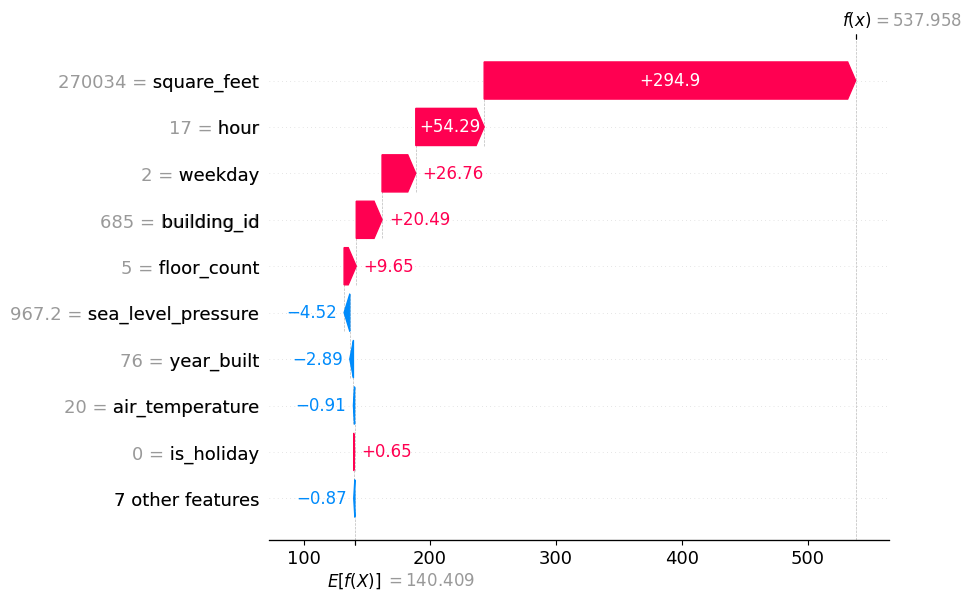

In [ ]:
# Figure 2 : Waterfall plot for a particular instance

# Specify the index of the data point you want to visualize
data_point_index = [5]

# Create the waterfall plot for the specified data point
for i in data_point_index:
   shap.plots.waterfall(shap_values[i])


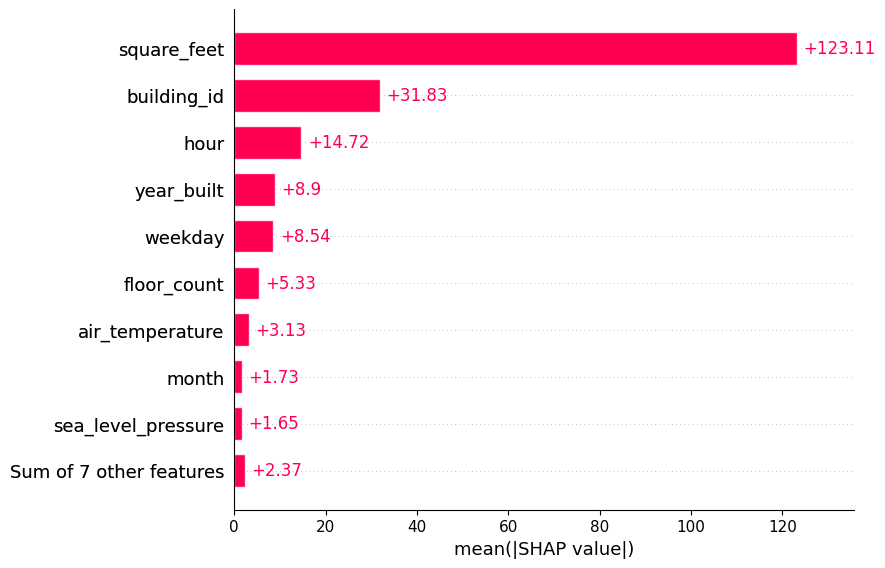

In [ ]:
# Figure 3 : barplot
shap.plots.bar(shap_values,show=False)

In [ ]:
feature_names = all_data.columns
feature_names

Index(['building_id', 'site_id', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'hour', 'weekday', 'month', 'is_holiday'],
      dtype='object')

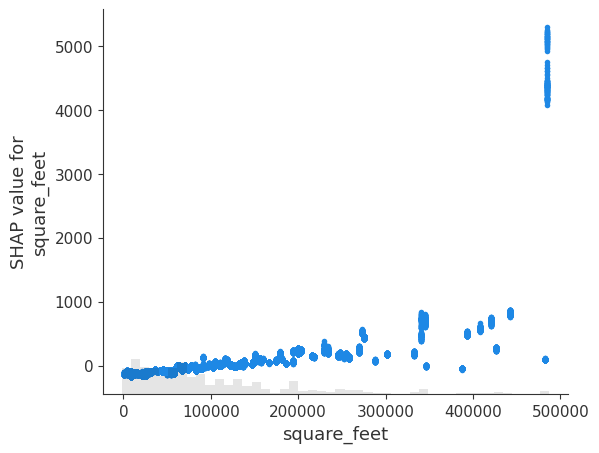

In [ ]:
# Figure 4 : Scatter sq. feat
shap.plots.scatter(shap_values[:, feature_names[2]])

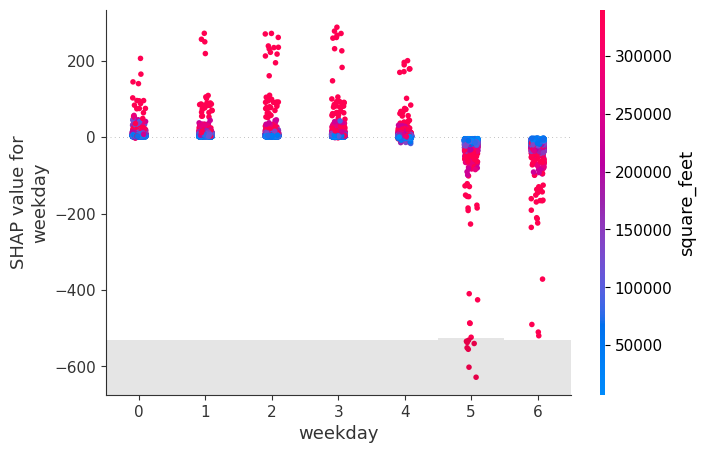

In [ ]:
# Figure 5 : Dependency plot weekday

shap.plots.scatter(shap_values[:,"weekday"], color=shap_values[:,"square_feet"],)

Anomaly detection

In [ ]:
with open("train_data_anom.pkl", "rb") as input_file:
  trainwona = pickle.load(input_file)

X_train = trainwona[trainwona['month']<9]
X_test = trainwona[trainwona["month"]>=9]



neg = X_train[X_train['anomaly'] == 0]
pos = X_train[X_train['anomaly'] == 1]
neg = neg.sample(n = len(pos), random_state=10)
X_train = pd.concat([neg, pos], axis=0)


Y_train = X_train["anomaly"]
X_train = X_train.drop(columns = ["anomaly"])

Y_test = X_test["anomaly"]
X_test = X_test.drop(columns = ["anomaly"])

# will add the training shap part later ...

## Plotting shap figures

In [ ]:
with open("shap anomdetect/anomaly_shap.pkl", "rb") as f:
  shap_values = pickle.load(f)

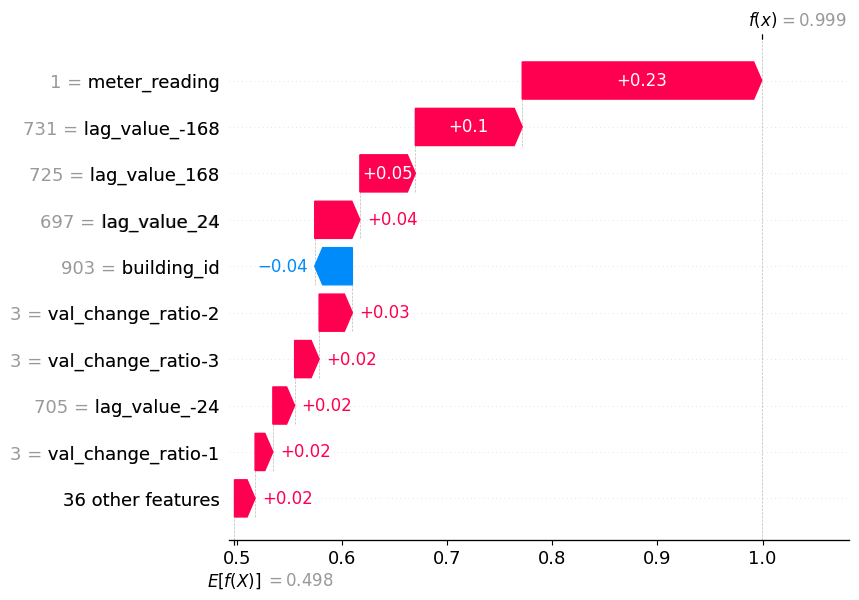

In [ ]:
# Figure 6 : waterfall plot for an instance


# Specify the index of the data point you want to visualize
data_point_index = [8]

# Create the waterfall plot for the specified data point
for i in data_point_index:
   shap.plots.waterfall(shap_values[i])


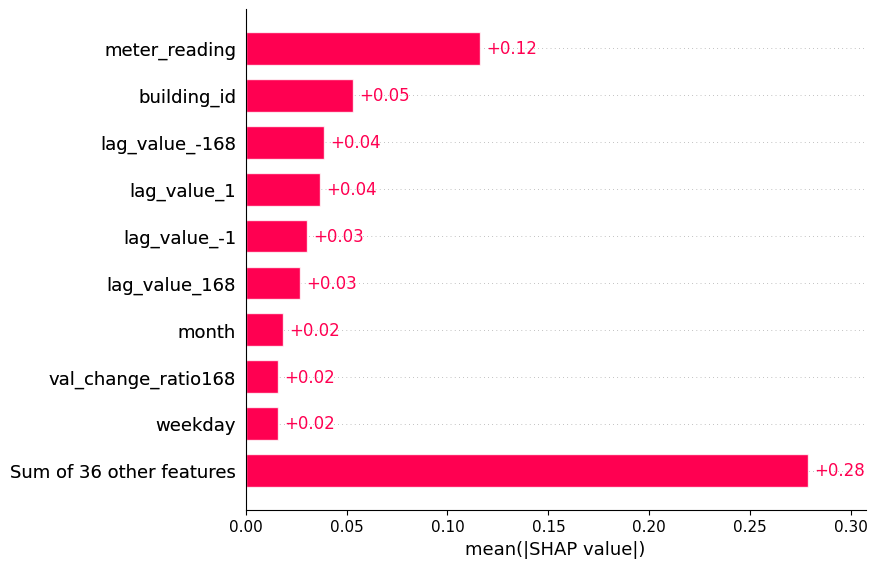

In [ ]:
# Figure 7 :

shap.plots.bar(shap_values,show=False)

In [ ]:


feature_names = X_train.columns
print(feature_names)


Index(['building_id', 'meter_reading', 'site_id', 'square_feet', 'year_built',
       'floor_count', 'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'hour', 'weekday', 'month', 'is_holiday',
       'val_change_ratio-1', 'lag_value_-1', 'val_change_ratio1',
       'lag_value_1', 'val_change_ratio2', 'lag_value_2', 'val_change_ratio-2',
       'lag_value_-2', 'val_change_ratio3', 'lag_value_3',
       'val_change_ratio-3', 'lag_value_-3', 'val_change_ratio5',
       'lag_value_5', 'val_change_ratio-5', 'lag_value_-5',
       'val_change_ratio12', 'lag_value_12', 'val_change_ratio-12',
       'lag_value_-12', 'val_change_ratio-24', 'lag_value_-24',
       'val_change_ratio24', 'lag_value_24', 'val_change_ratio-168',
       'lag_value_-168', 'val_change_ratio168', 'lag_value_168'],
      dtype='object')


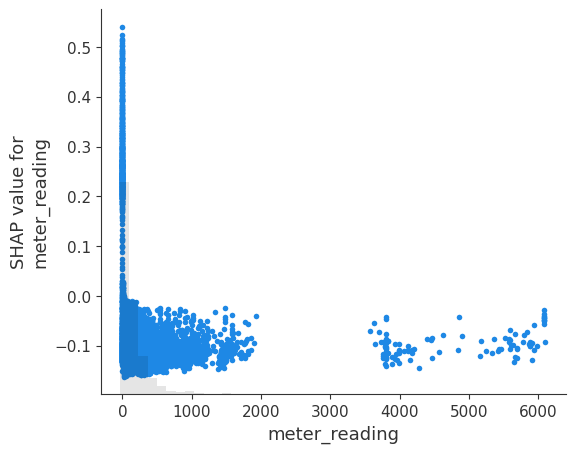

In [ ]:
# Figure 8 :
shap.plots.scatter(shap_values[:, feature_names[1]])

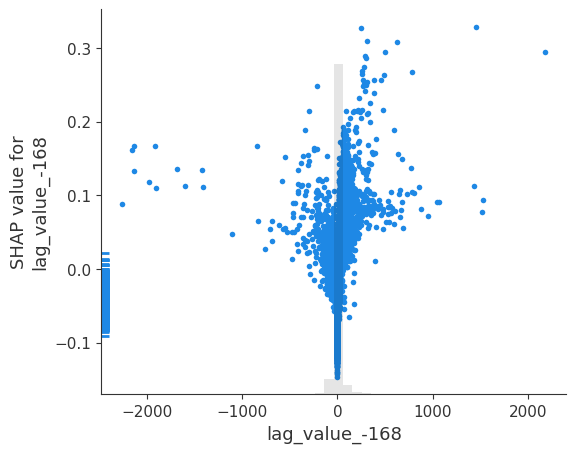

In [ ]:
# Figure 9 :

shap.plots.scatter(shap_values[:, feature_names[-3]])

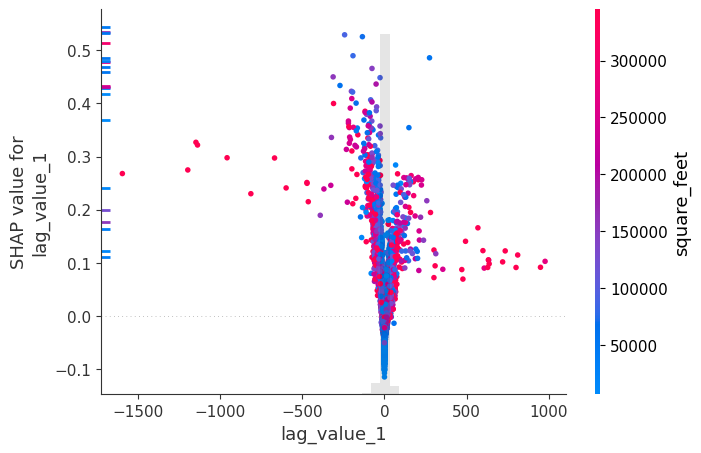

In [ ]:

shap.plots.scatter(shap_values[:,"lag_value_1"], color=shap_values[:,"square_feet"],)